In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from pathlib import Path
import numpy as np
from __future__ import annotations
from pathlib import Path
import re

Definindo o caminho do csv (run_logs) e definindo os nomes (colunas) que ele deve ter. 

In [201]:
CSV_PATH = Path("results/run_logs.csv")
COLS = ["modo","num_processos","tempo_clock","tempo_cpu",
        "tempo_comunicacao","tempo_total","timestamp","notas"]

Lê, carrega e prepara o csv. 

In [202]:
def ler_csv(caminho: Path, cols: list[str]) -> pd.DataFrame:
    df = pd.read_csv(caminho, names=cols)
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    for c in ("tempo_clock", "num_processos"):
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

df = ler_csv(CSV_PATH, COLS)

    Cálculos

Calcula o speedup do linear e do paralelo local e classifica o tipo. 
Baseado no csv e com o tempo linear calculado manualmente para as matrizes 4096x4096.

Calcula o speedup normal onde:

*T1:* tempo de execução no modo linear;

*TP:* tempo de execução usando p processos. 

In [203]:
def speedupN(T1, Tp):
    return (T1 / Tp) if (Tp and Tp > 0) else np.nan

Calcula o speedup do modo distribuido, corrigindo o tempo medido para representar o mesmo do linear. Já que ele executou apenas uma parte da matriz. (2048x4096). Então o TP significa apenas metade do trabalho total. 
Corrige isso aplicando um fator de ajuste proporcional ao tamanho processado. 

In [ ]:
def speedup_distribuido(T1, Tp, *, linhas_totais_A=None, linhas_processadas_A=None):
    if linhas_totais_A is not None and linhas_processadas_A is not None and linhas_processadas_A > 0:
        fator = float(linhas_totais_A) / float(linhas_processadas_A)
    else:
        fator = 1.0
    Tp_corr = Tp * fator
    return speedupN(T1, Tp_corr)

Decide qual fórmula usar dependendo do tipo de execução; 

Apenas retorna S, não classifica nada. 

In [ ]:
def speedup(T1, Tp, modo, *, linhas_totais_A=None, linhas_processadas_A=None):
    if modo == "linear":
        return 1.0
    elif modo in ("distribuido"):  
        return speedup_distribuido(T1, Tp,
                                   linhas_totais_A=linhas_totais_A,
                                   linhas_processadas_A=linhas_processadas_A)
    else:
        return speedupN(T1, Tp)

Classifica o speedup, baseado no valor de S. 

In [ ]:
def classificar_speedup(S, p, tol=0.05):
    if pd.isna(S) or p is None or p <= 0:
        return "indefinido"
    if S < 1 - tol:
        return "pior que linear"
    if abs(S - p) / p <= tol:
        return "linear"
    if S > p * (1 + tol):
        return "superlinear"
    return "sublinear"

Calcula a eficiência = speedup / n° de processos. 


In [ ]:
def eficiencia(S, p):
    return round(S / p, 4) if p else np.nan

Geração da tabela contendo o modo, tempo, eficiência, speedup e classificação. 

In [ ]:
def gerar_tabela_metricas_df(
    df: pd.DataFrame,
    tempo_col: str = "tempo_clock",
    linhas_totais_A: int = 4096,
    linhas_processadas_A: int = 2048
) -> pd.DataFrame:
    df = df.copy()
    df["modo"] = df["modo"].astype(str).str.strip()
    if "num_processos" in df.columns:
        df["num_processos"] = pd.to_numeric(df["num_processos"], errors="coerce")
    df[tempo_col] = pd.to_numeric(df[tempo_col], errors="coerce")

    df_lin = df[df["modo"].str.lower() == "linear"]
    if df_lin.empty:
        raise ValueError("Não foi encontrado linha do modo 'linear' no DataFrame.")
    if len(df_lin) != 1:
        raise ValueError("Há mais de uma linha para 'linear' (esperado exatamente 1).")
    T1 = float(df_lin[tempo_col].iloc[0])

    linhas = []
    for _, row in df.iterrows():
        modo_original = str(row["modo"]).strip()
        modo = modo_original.lower()
        Tp = float(row[tempo_col]) if pd.notna(row[tempo_col]) else np.nan
        p = int(row["num_processos"]) if pd.notna(row.get("num_processos", np.nan)) else (1 if modo == "linear" else np.nan)

        if modo == "linear":
            S = 1.0
            E = 1.0
            cls = "linear"
        else:
            S = speedup(
                T1, Tp, modo,
                linhas_totais_A=linhas_totais_A,
                linhas_processadas_A=linhas_processadas_A
            )
            E = eficiencia(S, p) if pd.notna(p) and p else np.nan
            cls = classificar_speedup(S, p) if pd.notna(p) and p else "indefinido"

        linhas.append({
            "Modo": modo_original,
            "p": p,
            "Tempo (s)": round(Tp, 3) if pd.notna(Tp) else np.nan,
            "Speedup": round(S, 4) if pd.notna(S) else np.nan,
            "Eficiência": round(E, 4) if pd.notna(E) else np.nan,
            "Classificação": cls
        })

    ordem = {"linear": 0, "paralelo_local": 1, "distribuida": 2, "distribuido": 2}
    out = pd.DataFrame(linhas)
    out["_ord"] = out["Modo"].str.lower().map(ordem).fillna(99).astype(int)
    out = out.sort_values(["_ord"]).drop(columns=["_ord"]).reset_index(drop=True)
    return out

def gerar_tabela_metricas_csv(
    csv_path: str = "results/run_logs.csv",
    tempo_col: str = "tempo_clock",
    linhas_totais_A: int = 4096,
    linhas_processadas_A: int = 2048
) -> pd.DataFrame:
    cols = ["modo","num_processos","tempo_clock","tempo_cpu",
            "tempo_comunicacao","tempo_total","timestamp","notas"]
    df = pd.read_csv(csv_path, names=cols)
    return gerar_tabela_metricas_df(
        df,
        tempo_col=tempo_col,
        linhas_totais_A=linhas_totais_A,
        linhas_processadas_A=linhas_processadas_A
    )

gerar_tabela_metricas_csv()

,Modo,p,Tempo (s),Speedup,Eficiência,Classificação
0,linear,1,38941.000,1.0000,1.0000,linear
1,paralelo_local,8,4867.663,7.9999,1.0000,linear
2,distribuido,2,12935.480,1.5052,0.7526,sublinear


    Gráficos

Gráfico de visualização de desempenho do modo linear. 
Quanto tempo ele demorou para multiplicar as matrizes de tamanho 4096x4096 sem paralelismo. 

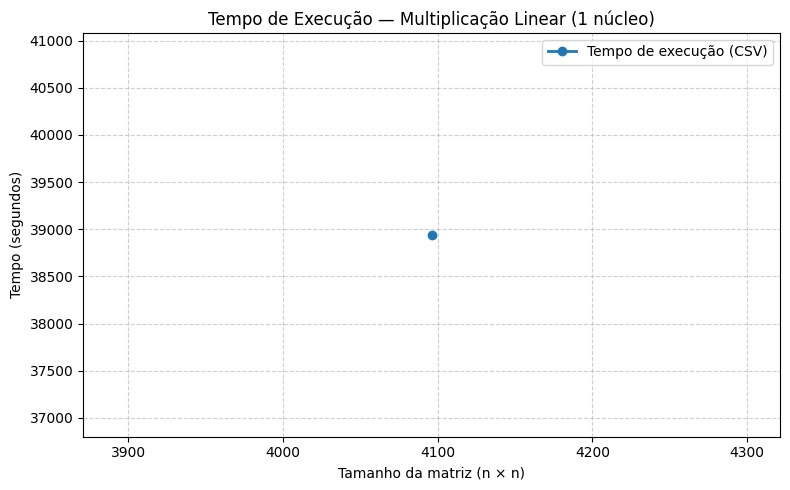

In [ ]:
def plot_linear(df: pd.DataFrame, n_padrao: int = 4096):
    df_lin = df[df["modo"] == "linear"].copy()
    if df_lin.empty:
        raise ValueError("Não há linhas do modo 'linear' no CSV. Rode o linear ou verifique o arquivo.")

    df_lin["tempo_clock"] = pd.to_numeric(df_lin["tempo_clock"], errors="coerce")
    if "timestamp" in df_lin.columns:
        df_lin["timestamp"] = pd.to_datetime(df_lin["timestamp"], errors="coerce")
        df_lin = df_lin.sort_values("timestamp").reset_index(drop=True)

    if "tamanho_n" not in df_lin.columns or df_lin["tamanho_n"].isna().all():
        df_lin["tamanho_n"] = n_padrao
    else:
        df_lin["tamanho_n"] = pd.to_numeric(df_lin["tamanho_n"], errors="coerce").fillna(n_padrao)

    df_lin = df_lin.dropna(subset=["tempo_clock", "tamanho_n"]).sort_values("tamanho_n")

    plt.figure(figsize=(8,5))
    plt.plot(
        df_lin["tamanho_n"], df_lin["tempo_clock"],
        marker="o", linewidth=2, label="Tempo de execução (CSV)"
    )
    plt.title("Tempo de Execução — Multiplicação Linear (1 núcleo)")
    plt.xlabel("Tamanho da matriz (n × n)")
    plt.ylabel("Tempo (segundos)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_linear(df, n_padrao=4096)

Gráfico para visualizar como o tempo de execução varia conforme o número de processos usados em um determinado modo. 

In [ ]:
def plot_por_processos(df: pd.DataFrame, modo: str, titulo: str):
    dff = df[df["modo"] == modo].copy()
    if dff.empty:
        print(f"Não há linhas com o modo: '{modo}'.")
        return
    dff = dff.dropna(subset=["num_processos","tempo_clock"]).sort_values("num_processos")

    plt.figure(figsize=(8,5))
    plt.plot(
        dff["num_processos"], dff["tempo_clock"],
        marker="o", linewidth=2, label="Tempo de execução (segundos)"
    )
    plt.title(titulo)
    plt.xlabel("Número de núcleos (processos)")
    plt.ylabel("Tempo de execução (segundos)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

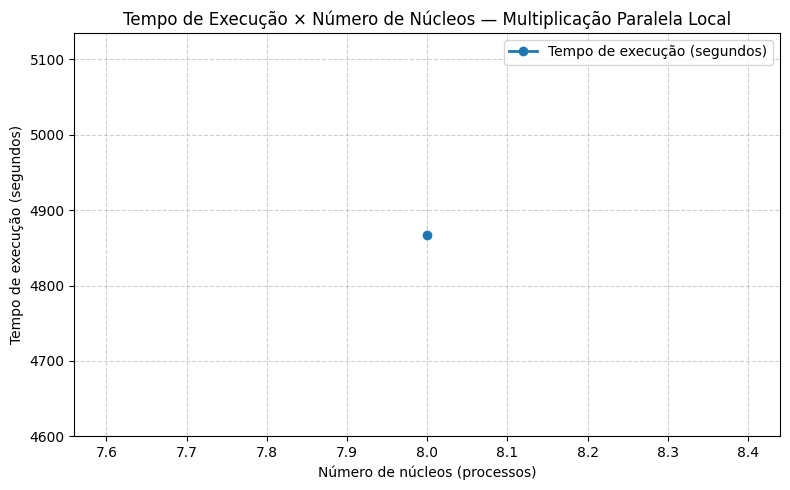

In [211]:
plot_por_processos(
    df, modo="paralelo_local",
    titulo="Tempo de Execução × Número de Núcleos — Multiplicação Paralela Local"
)

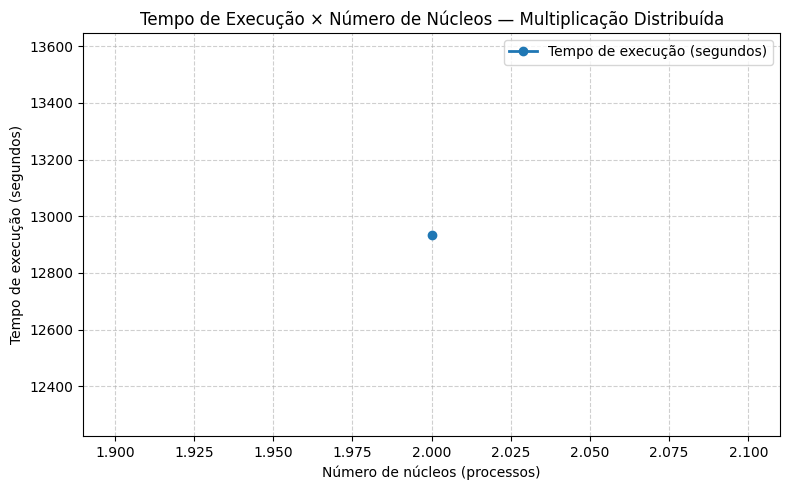

In [212]:
plot_por_processos(df, modo="distribuido",
                   titulo="Tempo de Execução × Número de Núcleos — Multiplicação Distribuída")

Gráfico comparando os tempos mais recentes em cada modo. Quanto menor, melhor. 

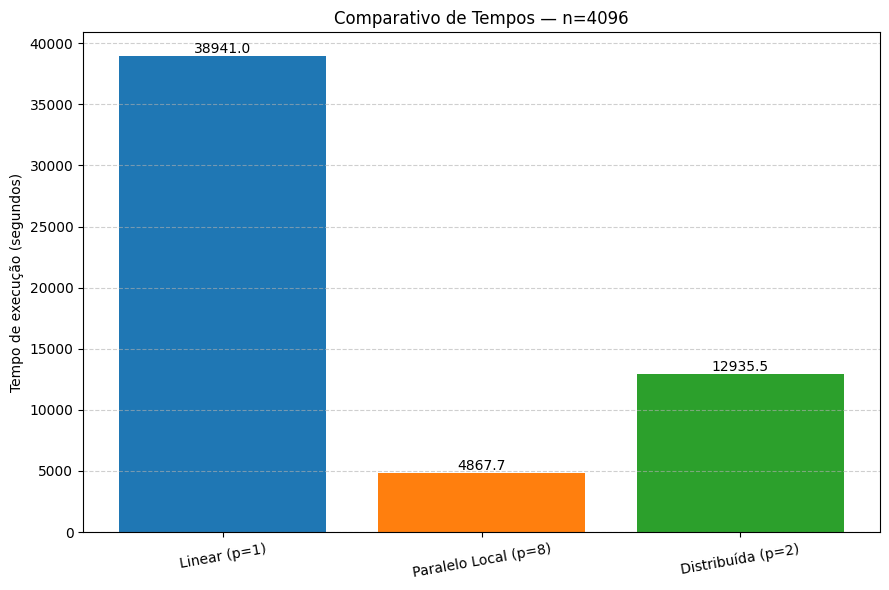

In [ ]:
def plot_comparativo_trio(df: pd.DataFrame, n_ref: int = 4096, usar_log=False):
    def pega_mais_recente(df_modo):
        if df_modo.empty:
            return None, None
        dm = df_modo.copy()
        dm["tempo_clock"] = pd.to_numeric(dm["tempo_clock"], errors="coerce")
        if "num_processos" in dm.columns:
            dm["num_processos"] = pd.to_numeric(dm["num_processos"], errors="coerce")
        dm = dm.dropna(subset=["tempo_clock"])
        if dm.empty:
            return None, None
        if "timestamp" in dm.columns:
            dm["timestamp"] = pd.to_datetime(dm["timestamp"], errors="coerce")
            dm = dm.sort_values("timestamp")
        row = dm.iloc[-1]
        p = int(row["num_processos"]) if "num_processos" in dm.columns and not pd.isna(row["num_processos"]) else 1
        return float(row["tempo_clock"]), p

    t_lin, p_lin = pega_mais_recente(df[df["modo"] == "linear"])
    t_par, p_par = pega_mais_recente(df[df["modo"] == "paralelo_local"])
    t_dis, p_dis = pega_mais_recente(df[df["modo"].isin(["distribuida","distribuido"])])

    labels, valores = [], []

    if t_lin is not None:
        labels.append(f"Linear (p=1)")
        valores.append(t_lin)
    if t_par is not None:
        labels.append(f"Paralelo Local (p={p_par})")
        valores.append(t_par)
    if t_dis is not None:
        labels.append(f"Distribuída (p={p_dis})")
        valores.append(t_dis)

    if not valores:
        print("Sem dados válidos para plotar.")
        return
    
    cores = ["#1f77b4", "#ff7f0e", "#2ca02c"][:len(valores)]  # azul, laranja, verde
    plt.figure(figsize=(9,6))
    barras = plt.bar(labels, valores, color=cores)

    if usar_log:
        plt.yscale("log")

    for barra in barras:
        altura = barra.get_height()
        plt.text(
            barra.get_x() + barra.get_width()/2,
            altura,
            f"{altura:.1f}",
            ha="center", va="bottom", fontsize=10
        )

    plt.ylabel("Tempo de execução (segundos)")
    plt.title(f"Comparativo de Tempos — n={n_ref}")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.xticks(rotation=10)
    plt.tight_layout()
    plt.show()

plot_comparativo_trio(df, n_ref=4096, usar_log=False)


Gráfico GEMM por host: desempenho bruto do processador em operações de ponto flutuante, compara quantos GFLOPS (bilhões de operações por segundo) cada host atingiu. 

Gráfico Benchamark escalar: operações puras em python, fora de bibliotecas otimizadas, compara quantas operações por segundo cada host conseguiu fazer. 

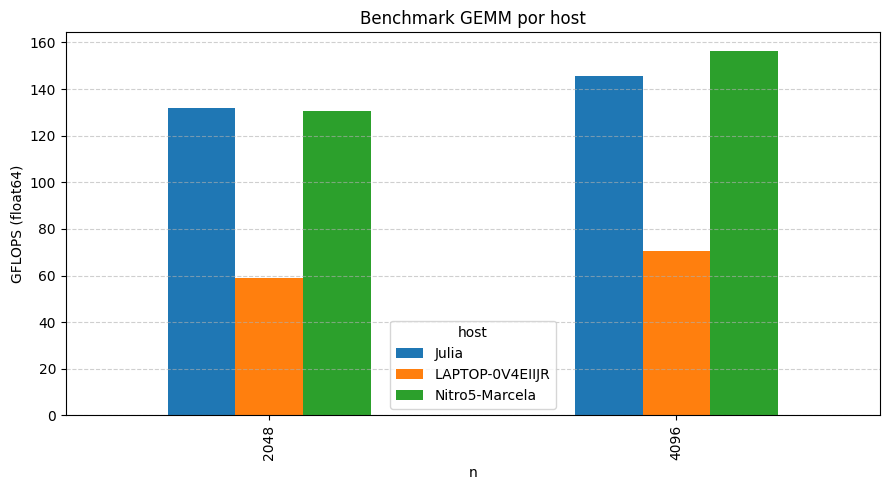

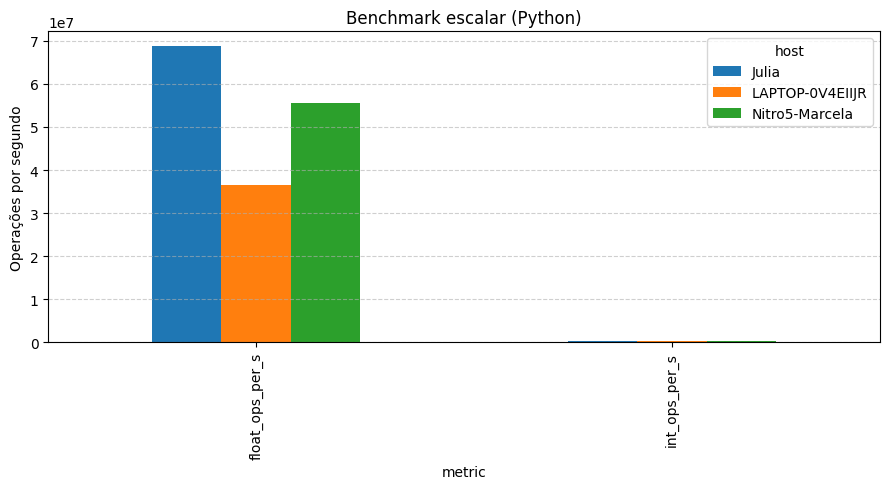

In [ ]:
src = Path("results/benchmarks.csv")
raw = src.read_text(encoding="utf-8", errors="ignore")
dst = Path("results/benchmarks_clean.csv")
raw_fixed = re.sub(r',(20\d{2}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2})', r'\n\1', raw)
dst.write_text(raw_fixed, encoding="utf-8")
dfb = pd.read_csv(dst)

subset = dfb.query("section=='gemm' and dtype=='float64'")
pivot = subset.pivot_table(index="n", values="value", columns="host", aggfunc='first').astype(float)
pivot.plot(kind="bar", figsize=(9,5))
plt.ylabel("GFLOPS (float64)")
plt.title("Benchmark GEMM por host")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

scalar = dfb.query("section=='scalar'")
pivot2 = scalar.pivot_table(index="metric", values="value", columns="host", aggfunc='first').astype(float)
pivot2.plot(kind="bar", figsize=(9,5))
plt.ylabel("Operações por segundo")
plt.title("Benchmark escalar (Python)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()